In [1]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import string
import nltk
from nltk.corpus import  stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
eml = pd.read_csv('emailspam.csv')
eml.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [3]:
eml.shape

(2893, 3)

In [4]:
eml.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [5]:
print ('nospam and spam counts','\n',eml.label.value_counts())

nospam and spam counts 
 0    2412
1     481
Name: label, dtype: int64


In [6]:
print ('spam ratio = ', round(len(eml[eml['label']==1]) / len(eml.label),2)*100,'%')
print ('nospam ratio  = ', round(len(eml[eml['label']==0]) / len(eml.label),2)*100,'%')

spam ratio =  17.0 %
nospam ratio  =  83.0 %


In [7]:
#New column for Length of message
eml['length'] = eml.message.str.len()
eml

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046
...,...,...,...,...
2888,love your profile - ysuolvpv,hello thanks for stopping by ! ! we have taken...,1,262
2889,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1,2163
2890,anglicization of composers ' names,"judging from the return post , i must have sou...",0,1039
2891,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0,2949


In [8]:
eml['message'] = eml['message'].str.lower()


In [9]:
# Replace email addresses with 'email'
eml['message'] = eml['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
eml['message'] = eml['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
eml['message'] = eml['message'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
eml['message'] = eml['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')   

# Replace numbers with 'numbr'
eml['message'] = eml['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [10]:
# Remove punctuation
eml['message'] = eml['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between teemlrms with a single space
eml['message'] = eml['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
eml['message'] = eml['message'].str.replace(r'^\s+|\s+?$', '')

In [11]:
eml.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [12]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
            result.append(lemmatize_stemming(token))        
    return result

In [13]:

# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

eml['message'] = eml['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

eml['message'] = preprocess(eml['message'])

In [14]:
# New column (clean_length) after puncuations,stopwords removal
eml['clean_length'] = eml.message.str.len()
eml.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2179
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1452
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0,1435,1064
3,risk,colleague researching differing degrees risk p...,0,324,210
4,request book information,earlier morning phone friend mine living south...,0,1046,629


In [15]:
# Total length removal
print ('Origian Length', eml.length.sum())
print ('Clean Length', eml.clean_length.sum())

Origian Length 9344743
Clean Length 6766226


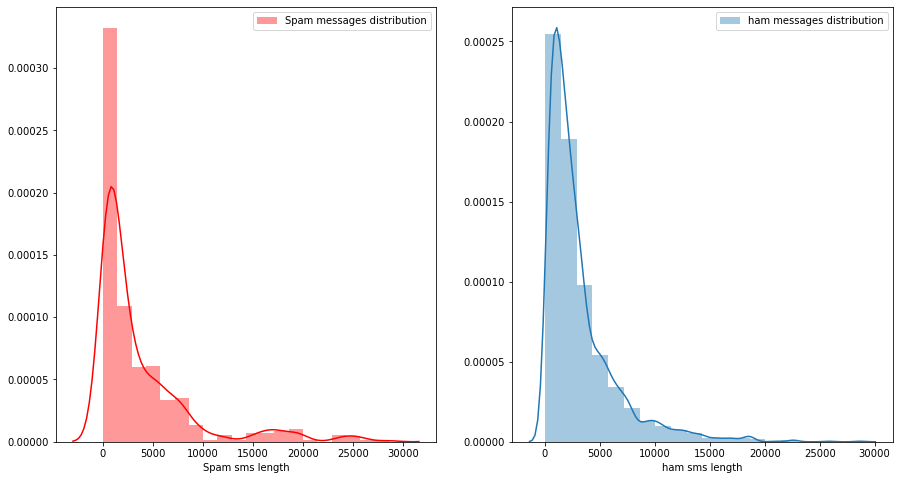

In [16]:

# Message distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(eml[eml['label']==1]['length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')

ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(eml[eml['label']==0]['length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

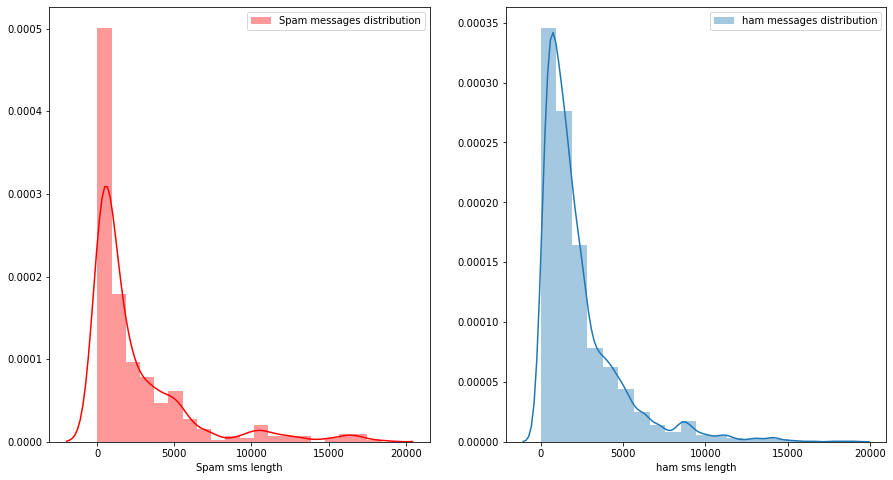

In [17]:

# Message distribution AFTER cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(eml[eml['label']==1]['clean_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')
ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(eml[eml['label']==0]['clean_length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

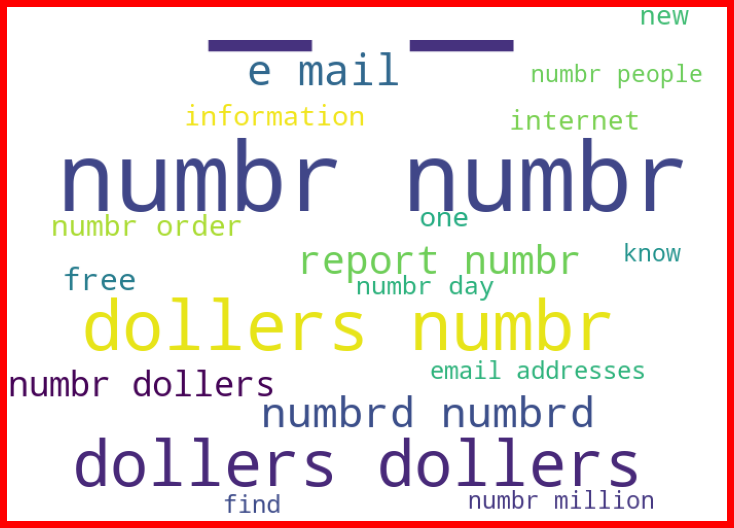

In [18]:

#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = eml['message'][eml['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

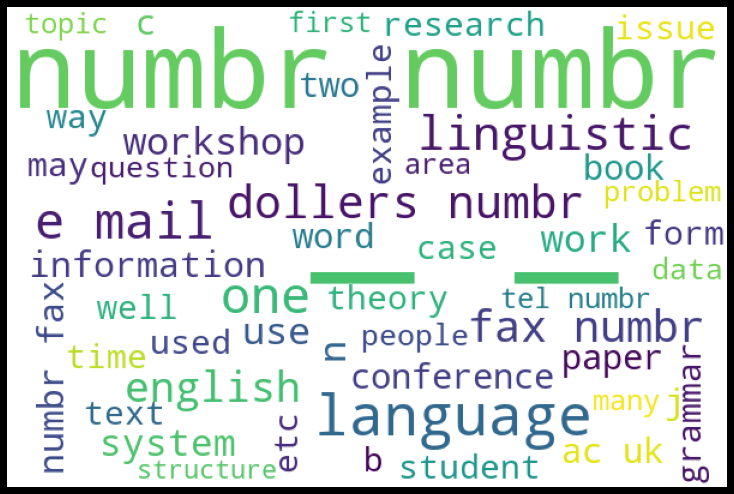

In [19]:

#Getting sense of loud words in ham 

hams = eml['message'][eml['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [20]:
tf_vec = TfidfVectorizer()

naive = MultinomialNB()

features = tf_vec.fit_transform(eml['message'])

X = features
y = eml['label']

In [21]:

# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8342541436464088


In [22]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       585
           1       1.00      0.14      0.24       139

    accuracy                           0.83       724
   macro avg       0.91      0.57      0.57       724
weighted avg       0.86      0.83      0.78       724



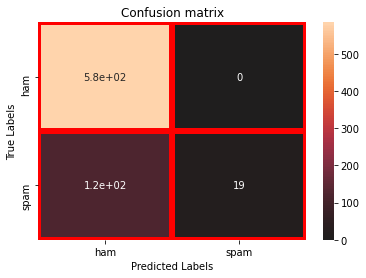

In [24]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [25]:

conf_mat

array([[585,   0],
       [120,  19]], dtype=int64)